In [2]:
import keras
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import distance
import random
import time
import urllib.request
import io
import glob

from src.fetch_data_pipeline import extract_image_url, extract_df, download_images, load_RG_data, zip_lookup, gps_lookup
import json

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
model = vgg16.VGG16(include_top = True, weights = 'imagenet')
model.layers.pop()
model.layers.pop()
model.outputs = [model.layers[-1].output]
#remove the next fully connected layer (fc7)
#remove the classification layer (fc8) softmax?
#Stripped down model with 4096 category output
#fix the output of the model

In [ ]:
#Full vgg16
[<keras.engine.input_layer.InputLayer at 0x1aafbcf2b0>,
 <keras.layers.convolutional.Conv2D at 0x1ab00d4e80>,
 <keras.layers.convolutional.Conv2D at 0x1ab00d46d8>,
 <keras.layers.pooling.MaxPooling2D at 0x1ab0bd20f0>,
 <keras.layers.convolutional.Conv2D at 0x1aae8eedd8>,
 <keras.layers.convolutional.Conv2D at 0x1aaf356dd8>,
 <keras.layers.pooling.MaxPooling2D at 0x1aaf84ac88>,
 <keras.layers.convolutional.Conv2D at 0x1a7025d550>,
 <keras.layers.convolutional.Conv2D at 0x1aae42fa90>,
 <keras.layers.convolutional.Conv2D at 0x1aae8867b8>,
 <keras.layers.pooling.MaxPooling2D at 0x1aaddc9a58>,
 <keras.layers.convolutional.Conv2D at 0x1aac093940>,
 <keras.layers.convolutional.Conv2D at 0x1aaba4e2b0>,
 <keras.layers.convolutional.Conv2D at 0x1aaa1bccc0>,
 <keras.layers.pooling.MaxPooling2D at 0x1a6e7e6940>,
 <keras.layers.convolutional.Conv2D at 0x1a6dafbda0>,
 <keras.layers.convolutional.Conv2D at 0xb2f0ea0b8>,
 <keras.layers.convolutional.Conv2D at 0xb2f0ea2b0>,
 <keras.layers.pooling.MaxPooling2D at 0xb24c75c18>,
 <keras.layers.core.Flatten at 0xb18b03f28>,
 <keras.layers.core.Dense at 0xb2f333518>,
 <keras.layers.core.Dense at 0x1aaa750dd8>,
 <keras.layers.core.Dense at 0x1ab3fa36d8>]

#Original pop off
<keras.engine.input_layer.InputLayer at 0xb24363a90>,
 <keras.layers.convolutional.Conv2D at 0xb24350668>,
 <keras.layers.convolutional.Conv2D at 0xb17f81da0>,
 <keras.layers.pooling.MaxPooling2D at 0xb17f81c88>,
 <keras.layers.convolutional.Conv2D at 0xb18574080>,
 <keras.layers.convolutional.Conv2D at 0xb18574da0>,
 <keras.layers.pooling.MaxPooling2D at 0xb18592550>,
 <keras.layers.convolutional.Conv2D at 0xb185ab898>,
 <keras.layers.convolutional.Conv2D at 0xb185c7cf8>,
 <keras.layers.convolutional.Conv2D at 0xb185e23c8>,
 <keras.layers.pooling.MaxPooling2D at 0xb185fca20>,
 <keras.layers.convolutional.Conv2D at 0xb18619b70>,
 <keras.layers.convolutional.Conv2D at 0xb18633ef0>,
 <keras.layers.convolutional.Conv2D at 0xb1864e3c8>,
 <keras.layers.pooling.MaxPooling2D at 0xb18665780>,
 <keras.layers.convolutional.Conv2D at 0xb189c38d0>,
 <keras.layers.convolutional.Conv2D at 0xb189e0c50>,
 <keras.layers.convolutional.Conv2D at 0xb189e0f60>,
 <keras.layers.pooling.MaxPooling2D at 0xb18a0d6d8>,
 <keras.layers.core.Flatten at 0xb18a2d630>,
 <keras.layers.core.Dense at 0xb18a2dd30>

PIL image size (224, 224)


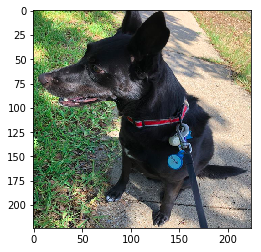

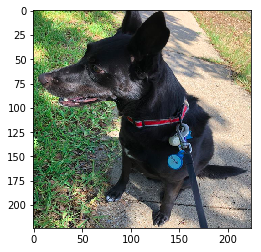

numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)


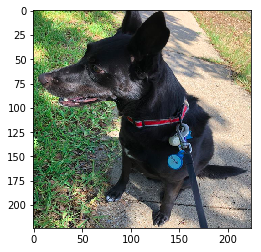

In [84]:
#filename_a = 'data/aww.png'
#filename_a = 'data/test1.png'
#filename_a = 'data/test2.png'
#filename_a = 'data/test3.png'
#filename_a = 'data/mossy1.png'
#filename_a = 'data/Nibu.png'
filename_a = 'data/dyno.png'
#filename_a = 'data/cool.png'

# Load image
original_a = load_img(filename_a, target_size=(224, 224))
print('PIL image size', original_a.size)
plt.imshow(original_a)
plt.show()
 
# Convert image to numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image_a = img_to_array(original_a)
plt.imshow(np.uint8(numpy_image_a))
plt.show()
print('numpy array size',numpy_image_a.shape)
 
# Convert the image into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch_a = np.expand_dims(numpy_image_a, axis=0)
print('image batch size', image_batch_a.shape)
plt.imshow(np.uint8(image_batch_a[0]))

In [85]:
# prepare the image for the VGG model
processed_image_a = vgg16.preprocess_input(image_batch_a.copy())

# get the predicted probabilities for each class
predictions_a = model.predict(processed_image_a)

print(predictions_a)

[[24.58171  29.871387  0.       ...  0.        0.        0.      ]]


In [ ]:
feature_array_4750 = np.load('web/static/temp/data/doggie_features_4750.npy')

In [ ]:
dog_url = combined_df.ImageUrl[0:4750]

In [ ]:
def top_matches(labels,score):
    sorted_scores = sorted(list(zip(labels.tolist(),score)), key = lambda t: t[1])
    return sorted_scores[0:10]

In [4]:
combined_df, combined_imgs = load_RG_data()

Total Records:  49755
Total Images:  143562


In [ ]:
dog_url = combined_df.ImageUrl[0:4750]
zipped_dogs = list(zip(dog_url.tolist(),results))
sorted_zipped_dogs = sorted(zipped_dogs, key = lambda t: t[1])
top_10 = sorted_zipped_dogs[0:11]
#top_10

In [ ]:
# Top 10 - Random

for x in range(0,11):
    image = random.choice(dog_url.tolist())
    plt.imshow(load_img('/Users/bil2ab/galvanize/RG5kimages/'+image.split('/')[-1]))
    plt.show()
    #print(1-score)

In [ ]:
#Load NumPy data file of 4750 dogs and calculate average number of non-zero features in 1D arrays for all dogs

non_zero_features = []
feature_array_4750 = np.load('web/static/temp/data/doggie_features_4750.npy')

for dog in feature_array_4750:
    non_zero_features.append(len(np.where(dog>0)[1]))

plt.hist(non_zero_features)

In [ ]:
for scores in score_lists:
    for image,score in top_ten(dog_url, scores):
        plt.imshow(load_img('/Users/bil2ab/galvanize/RG5kimages/'+image.split('/')[-1]))
        plt.show()
        #print(1-score)
        #print('DURKA DURKA...next distance metric:')

In [ ]:

    start = time.time()
    feature_array_list = []
    #image_path_list formerly combined_df.ImageUrl[0:4750]
    for url in image_path_list[0:length]:
        image_path = '/Users/bil2ab/galvanize/capstone/images_to_vectorize/images/'+url.split('/')[-1]
        dog = load_img(image_path, target_size=(224, 224))
        numpy_image = img_to_array(dog)
        image_batch = np.expand_dims(numpy_image, axis=0)  
        processed_image = vgg16.preprocess_input(image_batch.copy())
        feature_array = model.predict(processed_image)
        feature_array_list.append(feature_array)
        #doggie = np.asarray(feature_array_list)
        #np.save('data/RG_50k_features', doggie)
    end = time.time()
    total_time = end-start
    print('Total Time: '+str(total_time))
    print('All dog features vectorized!')
    return feature_array_list

In [ ]:
url_vec = combined_imgs.ImageUrl.tolist()
holy_durka = vectorize_dog_images(url_vec, length=50000)
#len(url_50k)

In [88]:
def durka():
    '''
    image_path_list = combined_df.ImageUrl.tolist()
    Take collection of dog images and vectorize each image to a 1D NumPy array. 
    INPUT: List, Pandas Series, some iterable of filepaths to dog images (strings)
    OUTPUT: Returns Numpy data file
    '''
    start = time.time()
    combined_df, combined_imgs = load_RG_data()
    #num_images = len(glob.glob1('/Users/bil2ab/galvanize/RG5kimages/','*.jpg'))
    image_path_list = combined_imgs.ImageUrl.tolist()
    feature_matrix = np.zeros((len(image_path_list),4096))
    
    for idx,url in enumerate(image_path_list):
        dog = load_img('/Users/bil2ab/galvanize/RG5kimages/'+url.split('/')[-1], target_size=(224, 224))
        image_batch = np.expand_dims(img_to_array(dog), axis=0)  
        processed_image = vgg16.preprocess_input(image_batch.copy())
        feature_matrix[idx] = model.predict(processed_image)
    
    #Save csv of image urls
    image_path_list.to_csv('/data/dog_urls_test.csv')
    
    #Save list of feature arrays as numpy data file
    #doggie = np.asarray(feature_array_list)
    np.save('/data/doggie_features_test', feature_matrix)
    
    end = time.time()
    print('Total Time: '+str(end-start))
    print('All dog features vectorized!')
    return feature_matrix

In [9]:
feature_matrix

1000

In [71]:
%timeit np.dot(predictions_a, feature_matrix.T) / (np.linalg.norm(feature_matrix, axis=1) * np.linalg.norm(predictions_a))

19.2 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
%timeit distance.cdist(predictions_a,feature_matrix,'cosine')[0]

12.6 ms ± 778 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


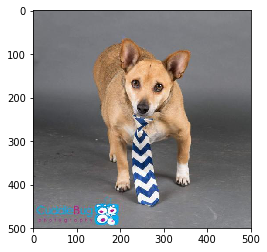

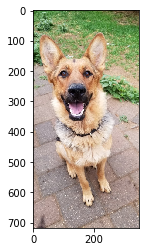

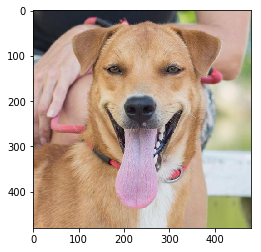

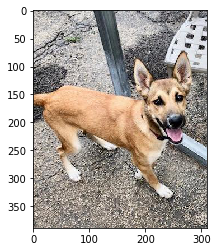

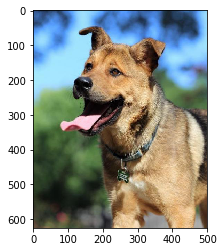

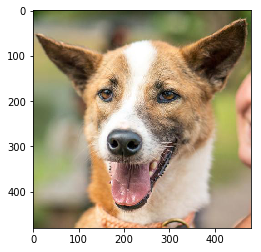

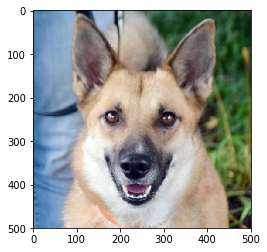

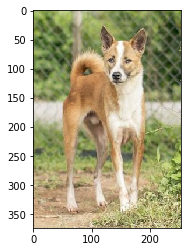

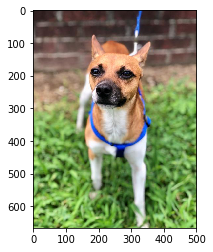

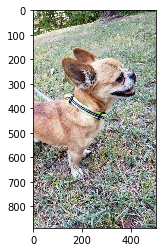

In [82]:
labels = combined_df.ImageUrl.tolist()[0:1000]
score = distance.cdist(predictions_a,feature_matrix,'cosine')[0].tolist()

if len(labels) == len(score):
    sorted_scores = sorted(list(zip(labels,score)), key = lambda t: t[1])
else:
    print('Length mismatch!')

for image, score in sorted_scores[0:10]:
    plt.imshow(load_img('/Users/bil2ab/galvanize/RG5kimages/'+image.split('/')[-1]))
    plt.show()


In [83]:
sorted_scores[0:10]

[('https://s3.amazonaws.com/filestore.rescuegroups.org/6725/pictures/animals/13398/13398452/59454464_500x500.jpg',
  0.5268085064001014),
 ('https://s3.amazonaws.com/filestore.rescuegroups.org/8343/pictures/animals/13398/13398412/59452612_349x718.jpg',
  0.5278684925553567),
 ('https://s3.amazonaws.com/filestore.rescuegroups.org/5922/pictures/animals/13398/13398199/59443336_480x480.jpg',
  0.5416557517821119),
 ('https://s3.amazonaws.com/filestore.rescuegroups.org/2573/pictures/animals/13398/13398277/59446077_311x389.jpg',
  0.5443417219280586),
 ('https://s3.amazonaws.com/filestore.rescuegroups.org/6659/pictures/animals/13398/13398323/59449100_500x625.jpg',
  0.549003782130904),
 ('https://s3.amazonaws.com/filestore.rescuegroups.org/5922/pictures/animals/13398/13398498/59454729_480x480.jpg',
  0.5519775897817951),
 ('https://s3.amazonaws.com/filestore.rescuegroups.org/6329/pictures/animals/13398/13398470/59454578_500x500.jpg',
  0.555849580191432),
 ('https://s3.amazonaws.com/filestor

In [ ]:
#Load the VGG model
#vgg_model = vgg16.VGG16(weights='imagenet')

#Load the Inception_V3 model
#inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
#resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
#mobilenet_model = mobilenet.MobileNet(weights='imagenet')


In [ ]:
#Function to extract exif data from smartphone image and view in nice format

from PIL.ExifTags import TAGS

#def extract_image_data(file):
filename =''
im = PIL.Image.open(filename)
exifdict = im._getexif()
#print(exifdict)

if len(exifdict):
    for k in exifdict.keys():
        if k in TAGS.keys():
            print(TAGS[k], exifdict[k])
        else:
            print(k, exifdict[k])